# Bayesian Network for the Grades of Portuguese Students
This notebook contains the code for the Bayesian Network calculating the grades of Portuguese students. The Bayesian Network is based on the analysis of the data from the *analyse-data.ipynb* notebook. The Bayesian Network is implemented using the *pgmpy* library and the train data is loaded from the *student-por_2.csv* file in the data folder.

## 0. Install required libraries
This section installs all needed libraries in a python virtual environment which can be used as Jupyter kernel. This needs only to be done once.

In [25]:
# ! python -m venv ../.env
# ! source ../.env/bin/activate
# ! pip install -r ../requirements.txt

## 1. Import libraries
This section imports all needed libraries and sets the path to the data, number of rows to be displayed.

In [26]:
%reset -f

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization 
from pgmpy.inference import VariableElimination, BeliefPropagation
# from pgmpy.sampling import RejectionSampling
from sklearn.model_selection import train_test_split

# Self-written modules for better code structure
from helpers.evaluation import MultiClassEvaluation, BinaryEvaluation
from app.preprocessing import TunedPreprocessing, BinaryPreprocessing, BoundOutPutPreprocessing, BinaryOutPutPreprocessing, Preprocessing

# Set matplotlib options
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Set pandas options
pd.set_option('display.max_columns', 500)

In [27]:
# Constants
DATA_PATH = "../data/"
RESULT_PATH = "../data/results/"
DOC_PATH = "../doc/"
MODEL_PATH = "../models/"
RANDOM_STATE = 1234
SPLIT = 0.2
WEIGHTS = False
NUMBER_CORES = 10 # !IMPORTANT: Set this to the number of cores of your machine for parallelization. It is recommended to use not all cores.

## 2. Load and prepare data
For the Bayesian Network we need to load the data from the *student-por_2.csv* file. The data is loaded using the *pandas* library. The data is prepared for the training by the following steps:

1. Delete the column *Unnamed: 33* which contains not explained data.

In [28]:
def delete_cols(data: pd.DataFrame, *args) -> pd.DataFrame:
    """Converts the data to a format that can be used for training and drops not needed columns.

    Args:
        data (pd.DataFrame): The data to be prepared.
        args (list): The additional columns to be dropped.
        
    Returns:
        pd.DataFrame: The prepared data.
    """
    for column in [*args, 'Unnamed: 33']:
        if column in data.columns:
            del data[column]
    return data

# EMPTY_COLS = [ 'G3']
# EMPTY_COLS = ['G1', 'G3']
# EMPTY_COLS = ['G2', 'G3']
# EMPTY_COLS = ['G1', 'G3', 'G2']
EMPTY_COLS = ['G1', 'G3', 'G2', 'studytime']

# Load the data
original_data = pd.read_csv(DATA_PATH + "student-por_2.csv", sep=";")
temp = original_data.copy()
# Add gaussian noise to the original data to avoid overfitting
# original_data[['G1', 'G2', 'G3']] = (original_data[['G1', 'G2', 'G3']] + np.random..normal(0, 1, (original_data.shape[0], 3))).apply(lambda row: row.round(0).astype(np.int64))
# original_data[['G1', 'G2', 'G3']] = (original_data[['G1', 'G2', 'G3']] + np.random.normal(0, 0.5, (original_data.shape[0], 3))).apply(lambda row: row.round(0).astype(np.int64)).apply(lambda row: row.clip(lower=0, upper=20))

if WEIGHTS:
    original_data.rename(columns={'Unnamed: 33': '_weight'}, inplace=True)
    original_data['_weight'] = original_data['_weight'].apply(lambda x: x.replace(',', '.')).astype(np.float64)

# (original_data[['G1', 'G2', 'G3']] - tmp).describe()
# original_data[['G1', 'G2', 'G3']].describe()


# original_data = original_data.drop(original_data[original_data['G3'] == 0].index)
# original_data = original_data.drop(original_data[original_data['G3'] == 1].index)

In [29]:



def preprocess(data: pd.DataFrame, firstPreprocessing: callable, second_preprocessing: callable = None) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train = data.copy()
    pre_first: Preprocessing = firstPreprocessing(train)
    pre_first.process()
    
    train = pre_first.processed_data.copy()
    if second_preprocessing:
        pre_second: Preprocessing = second_preprocessing(train)
        pre_second.process()
        train = pre_second.processed_data.copy()
    test = train.copy()
    if SPLIT < 1:
        train, test = train_test_split(train, test_size=SPLIT, random_state=RANDOM_STATE)
        train.reset_index(drop=True, inplace=True)
        test.reset_index(drop=True, inplace=True)
    labels = test.loc[:, EMPTY_COLS]
    test = delete_cols(test, *EMPTY_COLS)
    if (train.isna().sum() > 0).any() or (test.isna().sum() > 0).any() or (labels.isna().sum() > 0).any():
        raise ValueError("There are NaN values in the data. Please check the preprocessing.")
    if WEIGHTS:
        test = test.drop('_weight', axis=1)
    return train.copy(), test.copy(), labels.copy()
    

def setup_normal_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return preprocess(original_data, BinaryPreprocessing, BoundOutPutPreprocessing)

def setup_tuned_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return preprocess(original_data, TunedPreprocessing, BoundOutPutPreprocessing)

def setup_binary_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return preprocess(original_data, TunedPreprocessing, BinaryOutPutPreprocessing)

In [30]:
normal_train, normal_test, normal_labels = setup_normal_data()
tuned_train, tuned_test, tuned_labels = setup_tuned_data()
binary_train, binary_test, binary_labels = setup_binary_data()

## 3. Create Bayesian Network
In this section two different Bayesian Networks are created. The first one is a bigger model which contains all nodes and edges from the analysis of the data. The second one is a smaller to generalize the problem. The following code-box defines the possible states of the network. This is needed because the data represents not all possible states of the network.


In [31]:
g_states = ['<7'] + [f'{i}' for i in range(7, 18, 1)] + ['>17']
# g_states = [i for i in range(0, 21, 1)]
same_states = {
    "G1": g_states, 
    "G2": g_states, 
    "G3": g_states,
    "school": [0, 1],
    "sex": [0, 1],
    "age": [str(i) for i in range(15, 21, 1)] + ['>20'],
    "address": [0, 1],
    "famsize": [0, 1],
    "Pstatus": [0, 1],
    "reason": ["home", "reputation", "course", "other"],
    "guardian": ["mother", "father", "other"],
    "traveltime": [i for i in range(1, 5, 1)],
    "studytime": [i for i in range(1, 5, 1)],
    "failures": [i for i in range(0, 4, 1)],
    # "failures": [i for i in range(0, 2, 1)],
    "activities": [0, 1],
    "nursery": [0, 1],
    "higher": [0, 1],
    "internet": [0, 1],
    "romantic": [0, 1],
    "famrel": [i for i in range(1, 6, 1)],
    "health": [i for i in range(1, 6, 1)],
    "absences": [str(i) for i in range(0, 16, 1)] + ['>15'],
}

states_normal = same_states.copy()
states_normal["Fedu"] = [i for i in range(0, 5, 1)]
states_normal["Medu"] = [i for i in range(0, 5, 1)]
states_normal["Mjob"] = ["at_home", "teacher", "health", "services", "other"]
states_normal["Fjob"] = ["at_home", "teacher", "health", "services", "other"]
states_normal["famsup"] = [0, 1]
states_normal["schoolsup"] = [0, 1]
states_normal["freetime"] = [i for i in range(1, 6, 1)]
states_normal["goout"] = [i for i in range(1, 6, 1)]
states_normal["Dalc"] = [i for i in range(1, 6, 1)]
states_normal["Walc"] = [i for i in range(1, 6, 1)]

states_tuned = same_states.copy()
states_tuned["Pedu"] = [i for i in range(0, 5, 1)]
states_tuned["Pjob_at_home"] = [0, 1]
states_tuned["Pjob_teacher"] = [0, 1]
states_tuned["Pjob_health"] = [0, 1]
states_tuned["Pjob_service"] = [0, 1]
states_tuned["Pjob_other"] = [0, 1]
states_tuned["sup"] = [i for i in range(0, 4, 1)]
states_tuned["social"] = [i for i in range(1, 6, 1)]
states_tuned["alc"] = [i for i in range(1, 6, 1)]

states_binary = states_tuned.copy()
states_binary["G1"] = [i for i in range(0, 21, 1)]
states_binary["G2"] = [i for i in range(0, 21, 1)]
# states_binary["G1"] = [0, 1]
# states_binary["G2"] = [0, 1]
states_binary["G3"] = [0, 1]

### 3.1 Big Network
The Bayesian Network is created using the *pgmpy* library. For this we need to define the structure of nodes and edges of the network. After the analysis of the data in the *analyse-data.ipynb* notebook we came up with the following structure:

TODO: Add structure

First we define the structure of the network and then we add the conditional probability tables (CPT) to the nodes by "training" the network with the train data.

In [32]:
# Create Network
normal_network = BayesianNetwork()

# Add all columns as nodes
for col in normal_train.columns:
    if col != '_weight':
        normal_network.add_node(col)
    
# Add edges
edges = [
    # Grades
    # ('G1', 'G2'),
    ('G1', 'G3'),
    ('G2', 'G3'),
    
    # To G1 and G2
    ('reason', 'G1'),
    ('Medu', 'G1'),
    ('Fedu', 'G1'),
    ('school', 'G1'),
    ('failures', 'G1'),
    ('higher', 'G1'),
    # ('age', 'G1'),
    ('studytime', 'G1'),
    
    ('reason', 'G2'),
    ('Medu', 'G2'),
    ('Fedu', 'G2'),
    ('school', 'G2'),
    ('failures', 'G2'),
    ('higher', 'G2'),
    # # ('age', 'G2'),
    ('studytime', 'G2'),
    
    ('reason', 'G3'),
    ('Medu', 'G3'),
    ('Fedu', 'G3'),
    ('school', 'G3'),
    ('failures', 'G3'),
    ('higher', 'G3'),
    # # ('age', 'G3'),
    ('studytime', 'G3'),
    
    
    
    
    # Medu and Fedu
    ('Mjob', 'Medu'),
    ('Fjob', 'Fedu'),
    ('Mjob', 'Fedu'),
    ('Fjob', 'Medu'),
    ('Mjob', 'internet'),
    ('Fjob', 'internet'),
    ('famsup', 'Fedu'),
    ('famsup', 'Medu'),
    ('Medu', 'failures'),
    ('Fedu', 'failures'),
    ('Medu', 'higher'),
    ('Fedu', 'higher'),
    ('paid', 'Medu'),
    ('paid', 'Fedu'),
    ('nursery', 'Medu'),
    ('nursery', 'Fedu'),
    
    # Family
    ('nursery', 'famsize'),
    ('famsize', 'Pstatus'),
    ('guardian', 'Pstatus'),
    ('health', 'famrel'),
    ('famrel', 'freetime'),
    ('sex', 'famsup'),
    ('famsup', 'higher'),
    ('studytime', 'famsup'),
    
    
    # Free time
    ('sex', 'Dalc'),
    ('sex', 'Walc'),
    ('Dalc', 'Walc'),
    ('Walc', 'goout'),
    ('goout', 'freetime'),
    ('Pstatus', 'activities'),
    ('activities', 'freetime'),
    ('activities', 'failures'),
    ('freetime', 'failures'),
    ('Walc', 'absences'),
    ('activities', 'studytime'),
    ('Walc', 'studytime'),
    ('absences', 'failures'),
    ('absences', 'school'),
    ('absences', 'higher'),
    ('absences', 'age'),
    
    # School
    ('internet', 'address'),
    ('internet', 'school'),
    ('address', 'school'),
    ('school', 'traveltime'),
    ('address', 'traveltime'),
    ('school', 'schoolsup'),
    ('schoolsup', 'age'),
    ('schoolsup', 'studytime'),
    
    # Rest
    ('failures', 'higher'),
    ('age', 'higher'),
    ('romantic', 'age'),
    ('guardian', 'age'),
    ('studytime', 'higher',),
    
]

# Add edges to network and draw it
for edge in edges:
    normal_network.add_edge(*edge)

In [33]:
# Fit data
normal_network.fit(normal_train,
 state_names=states_normal,
 estimator=BayesianEstimator,
 prior_type="BDeu",
 equivalent_sample_size=len(normal_train),
 weighted=WEIGHTS,
 n_jobs=NUMBER_CORES,
)

### 3.2 Smaller Bayesian Network
The first Bayesian Network is really big and complex, with the problem that the computation time is very high and uses much of memory. Therefore a smaller network is created by merging some nodes. The merged nodes are used from the analysis of the data in the *analyse-data.ipynb* notebook.

#### Structure Learning


In [34]:
from pgmpy.estimators import HillClimbSearch, PC, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore

temp = tuned_train.copy()
temp.drop(columns=['G1', 'G2'], inplace=True)
hc = HillClimbSearch(temp, state_names=states_tuned)
# ex = ExhaustiveSearch(temp, scoring_method=K2Score(temp))
# best_model = ex.estimate()
best_model = hc.estimate(scoring_method=K2Score(temp), epsilon=0.0000001,tabu_length=1000, max_indegree=4)
# best_model = hc.estimate(scoring_method=BDeuScore(temp), epsilon=0.0000001,tabu_length=1000, max_indegree=1000, fixed_edges=[('G1', 'G3'), ('G2', 'G3')], black_list=[('G1', 'G2'), ('G2', 'G1')])

# pc = PC(data=temp)
# best_model = pc.estimate(variant='stable', max_cond_vars=10, significance_level=0.10, n_jobs=NUMBER_CORES)



  0%|          | 48/1000000 [00:04<25:47:44, 10.77it/s]


In [35]:
edges = best_model.edges()
for e in edges:
    print(e)

('school', 'reason')
('school', 'G3')
('school', 'absences')
('sex', 'studytime')
('sex', 'activities')
('sex', 'famsize')
('sex', 'Pjob_at_home')
('age', 'guardian')
('address', 'school')
('address', 'traveltime')
('famsize', 'nursery')
('Pstatus', 'famsize')
('guardian', 'Pstatus')
('guardian', 'romantic')
('studytime', 'activities')
('failures', 'G3')
('failures', 'age')
('failures', 'higher')
('failures', 'activities')
('higher', 'studytime')
('higher', 'Pedu')
('higher', 'social')
('higher', 'Pjob_at_home')
('internet', 'school')
('internet', 'traveltime')
('internet', 'famrel')
('internet', 'address')
('alc', 'sex')
('social', 'alc')
('Pedu', 'Pjob_at_home')
('Pedu', 'Pjob_teacher')
('Pedu', 'internet')
('Pedu', 'address')
('Pjob_teacher', 'Pjob_other')
('Pjob_teacher', 'Pjob_services')
('Pjob_teacher', 'sex')
('Pjob_teacher', 'school')
('Pjob_health', 'Pjob_services')
('Pjob_health', 'Pjob_other')
('Pjob_at_home', 'Pjob_services')
('Pjob_at_home', 'internet')
('Pjob_at_home', 'P

#### Parameter Learning

In [72]:
# Create Network
tuned_network = BayesianNetwork()

# Add all columns as nodes
for col in tuned_train.columns:
    if col != '_weight':
        tuned_network.add_node(col)

importand_edges = [
    # Medu and Fedu
    ('Pjob_at_home', 'internet'),
    # ('Pjob_at_home', 'Pedu'),
    # ('Pjob_teacher', 'Pedu'),
    # ('Pjob_health', 'Pedu'),
    # ('Pjob_other', 'Pedu'),
    # ('Pjob_services', 'Pedu'),
    ('Pjob_at_home', 'school'),
    ('Pjob_teacher', 'school'),
    ('Pjob_health', 'school'),
    ('Pjob_other', 'school'),
    ('Pjob_services', 'school'),
    # ('internet', 'Pjob_at_home'),
    ('Pedu', 'Pjob_at_home'),
    ('Pedu', 'Pjob_teacher'),
    ('Pedu', 'Pjob_health'),
    ('Pedu', 'Pjob_services'),
    ('Pedu', 'Pjob_other'),
    # ('school', 'Pjob_at_home'),
    # ('school', 'Pjob_teacher'),
    # ('school', 'Pjob_health'),
    # ('school', 'Pjob_services'),
    # ('school', 'Pjob_other'),
    ('Pedu', 'failures'),
    ('Pedu', 'higher'),
    ('Pedu', 'internet'),
    ('Pedu', 'school'),
    ('Pedu', 'sup'),
    ('Pedu', 'nursery'),
    ('Pedu', 'address'),
    
    # Family
    ('nursery', 'famsize'),
    ('famsize', 'Pstatus'),
    ('guardian', 'Pstatus'),
    ('health', 'famrel'),
    ('famrel', 'social'),
    ('sex', 'sup'),
    ('sup', 'higher'),
    ('sup', 'studytime'),
    ('school', 'sup'),
    ('age', 'sup'),
    ('age', 'alc'),
    ('sup', 'higher'),
    
    
    # Free time
    ('sex', 'alc'),
    ('alc', 'social'),
    ('alc', 'absences'),
    ('alc', 'studytime'),
    ('alc', 'health'),
    ('social', 'failures'),
    ('social', 'studytime'),
    ('activities', 'social'),
    ('activities', 'failures'),
    ('activities', 'studytime'),
    ('Pstatus', 'activities'),
    ('absences', 'failures'),
    ('absences', 'school'),
    ('absences', 'higher'),
    ('age', 'absences'),
    
    # School
    ('internet', 'address'),
    ('internet', 'school'),
    ('address', 'school'),
    ('school', 'traveltime'),
    ('address', 'traveltime'),
    ('sex', 'studytime'),
    
    # Rest
    ('failures', 'higher'),
    ('age', 'higher'),
    ('romantic', 'age'),
    ('guardian', 'age'),
    ('studytime', 'higher'),
]

# Add edges
edges = [
    # Grades
    ('G1', 'G3'),
    # ('G1', 'G2'),
    ('G2', 'G3'),
    
    # # To G1 and G2
    ('reason', 'G1'),
    # ('age', 'G1'),
    ('Pedu', 'G1'),
    # ('sup', 'G1'),
    ('school', 'G1'),
    ('failures', 'G1'),
    ('higher', 'G1'),
    # ('alc', 'G1'),
    # ('Pjob_at_home', 'G1'),
    # ('Pjob_teacher', 'G1'),
    # ('Pjob_health', 'G1'),
    # ('Pjob_services', 'G1'),
    # ('Pjob_other', 'G1'),
    # ('traveltime', 'G1'),
    ('studytime', 'G1'),
    
    ('reason', 'G2'),
    # ('age', 'G2'),
    ('Pedu', 'G2'),
    # ('sup', 'G2'),
    ('school', 'G2'),
    ('failures', 'G2'),
    ('higher', 'G2'),
    # ('alc', 'G1'),
    # ('Pjob_at_home', 'G2'),
    # ('Pjob_teacher', 'G2'),
    # ('Pjob_health', 'G2'),
    # ('Pjob_services', 'G2'),
    # ('Pjob_other', 'G2'),
    # ('traveltime', 'G2'),
    ('studytime', 'G2'),
    # ('address', 'G2'),
    
    
    
    ('reason', 'G3'),
    # ('age', 'G3'),
    # # # ('address', 'G3'),
    # ('Pedu', 'G3'),
    # ('sup', 'G3'),
    ('school', 'G3'),
    ('failures', 'G3'),
    ('higher', 'G3'),
    # # # # # ('alc', 'G3'),
    # ('Pjob_at_home', 'G3'),
    # ('Pjob_teacher', 'G3'),
    # ('Pjob_health', 'G3'),
    # ('Pjob_services', 'G3'),
    # ('Pjob_other', 'G3'),
    # ('traveltime', 'G3'),
    ('studytime', 'G3'),
]

# Add edges to network and draw it
for edge in edges + importand_edges:
    tuned_network.add_edge(*edge[:2], weight=edge[2] if len(edge) == 3 else 1)
    
tuned_not_trained = tuned_network.copy()

In [73]:
tuned_network.fit(tuned_train,
 state_names=states_tuned,
 estimator=BayesianEstimator,
 prior_type="K2",
 equivalent_sample_size=len(tuned_train),
 n_jobs=NUMBER_CORES,
 weighted = WEIGHTS
)

In [74]:
from pgmpy.factors.discrete.CPD import TabularCPD

def save_all(cpds):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    for cpd in cpds:
        with open(f"{DOC_PATH}/cpds/{cpd.variable}.txt", "w") as f:
            f.write(str(cpd))
    TabularCPD._truncate_strtable = backup



# Save CPDs
cpds = tuned_network.get_cpds()
# save_all(cpds)


### 3.3 Binary Bayesian Network (Passed/Failed)
**Hint:** This network is not used in the final application and was a first approach to measure the quality.

This network aims to generalize the problem into passed or failed. In the portuguese school system the grades are from 0 to 20. The grades 0 to 9 are failed and the grades 10 to 20 are passed. Therefore the grades are transformed into a binary value. The following code-box defines the possible states of the network. This is needed because the data represents not all possible states of the network.

In [75]:
binary_network = tuned_not_trained.copy()
binary_network.fit(binary_train,
 state_names=states_binary,
 estimator=BayesianEstimator,
 prior_type="K2",
 equivalent_sample_size=len(binary_train),
 n_jobs=NUMBER_CORES,
 weighted = WEIGHTS
)

## 3. Test Bayesian Network and evaluate results



In [76]:
def map_to_grade(grade_int) -> str:
    if grade_int == 0:
        return '<7'
    elif grade_int == 12:
        return '>17'
    else:
        return str(grade_int + 6)

def fast_prediction(model, data)->pd.DataFrame:
    pred = {'G3': [], 'likelihood': []}
    length = len(data.index)
    
    for row in data.iterrows():
        print(f"Predicting {row[0]}/{length}", end='\r')
        elimination = VariableElimination(model)
        # print({k: v for k, v in row[1].items() if k != 'G3'})
        estimation = elimination.query(variables=['G3'], evidence={k: v for k, v in row[1].items() if k != 'G3'}, joint=True)
        prediction = estimation.values
        pred['G3'].append(map_to_grade(prediction.argmax()))
        pred['likelihood'].append(prediction.max())
    pred_df = pd.DataFrame(pred)
    return pred_df

In [77]:
SKIP_BIG = True


### 3.1 Big Network
The Bayesian Network is tested with the test data loaded in step 2. The prepared test data is used to predict the grades of the students. The results are evaluated by comparing the predicted grades with the actual grades. The evaluation is done by calculating the accuracy of the predictions and a plot of the false positive, false negative predictions, true positive and true negative predictions.

In [78]:
# Create predictions
if not SKIP_BIG:
    # normal_predictions = normal_network.predict(normal_test, stochastic=False, n_jobs=NUMBER_CORES)
    normal_predictions = fast_prediction(normal_network, normal_test)
    normal_predictions.rename(columns={k: f"{k}_pred" for k in normal_predictions.columns}, inplace=True)

    # Save results for later evaluation
    tuned_result = pd.concat([normal_labels, normal_predictions], axis=1, join='inner')
    tuned_result.to_csv(RESULT_PATH + "normal_result.csv", index=False)

In [79]:
if not SKIP_BIG:
    normal_result = pd.read_csv(RESULT_PATH + "normal_result.csv")

    # Evaluate results
    evaluation = MultiClassEvaluation(normal_result, match='G3', is_string=True, min_grade=7, max_grade=17, offset=2)
    evaluation.print_stats()
    evaluation.plot()
    evaluation.plot_confusion_matrix()

### 3.2 Smaller Bayesian Network

In [80]:
# Create predictions

tuned_predictions = tuned_network.predict(tuned_test, stochastic=False, n_jobs=NUMBER_CORES)
# tuned_predictions = fast_prediction(tuned_network, tuned_test)
tuned_predictions.rename(columns={k: f"{k}_pred" for k in tuned_predictions.columns}, inplace=True)

# Save results for later evaluation
tuned_result = pd.concat([tuned_labels, tuned_predictions], axis=1, join='inner')
tuned_result.to_csv(RESULT_PATH + "tuned_results.csv", index=False)

100%|██████████| 120/120 [00:04<00:00, 26.38it/s]


/home/tom/projects/probability-ki/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.1
Mean false error: 2.7314814814814814
Mean absolute error: 2.4583333333333335
Precision: 0.029985408246277805
Recall: 0.06563375895359701
F1 score: 0.0405982905982906


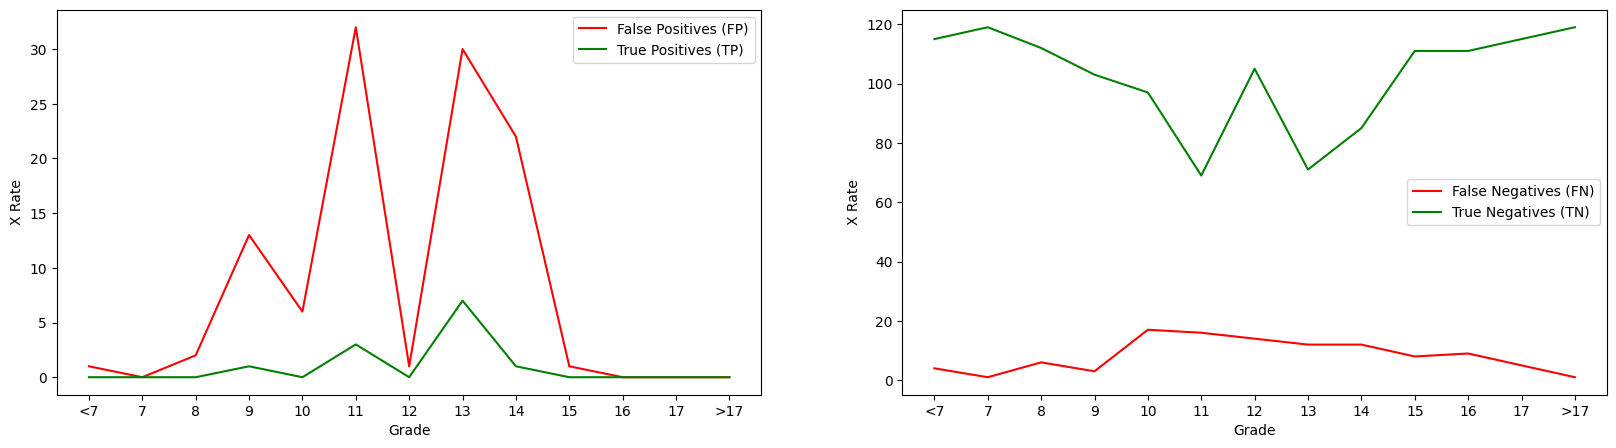

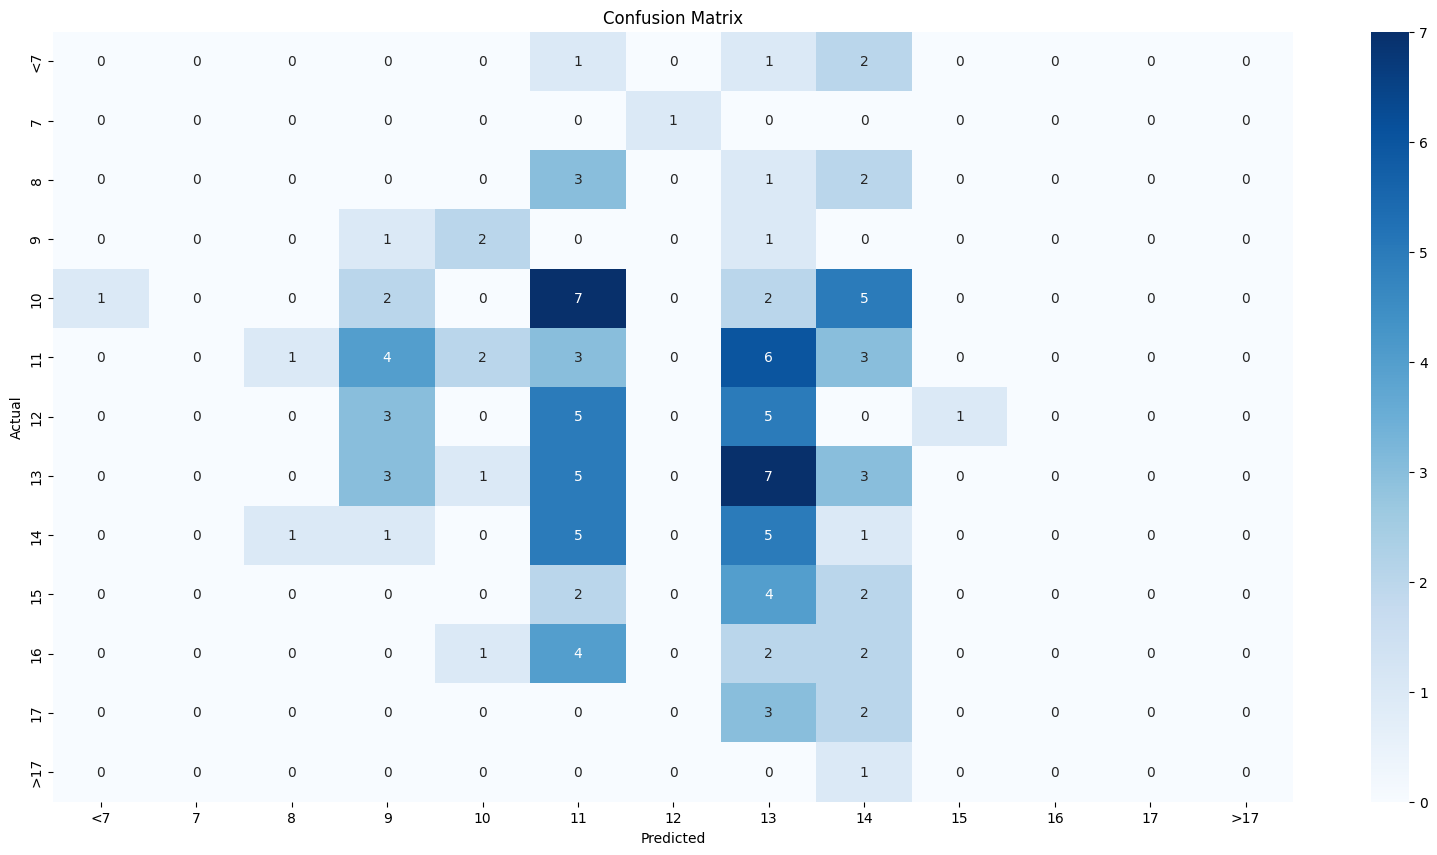

In [ ]:
tuned_result = pd.read_csv(RESULT_PATH + "tuned_results.csv")

# Evaluate results
evaluation_tuned = MultiClassEvaluation(tuned_result, match='G3', is_string=True, min_grade=7, max_grade=17, offset=2)
evaluation_tuned.print_stats()
evaluation_tuned.plot()
evaluation_tuned.plot_confusion_matrix()

In [ ]:
# tuned_test.loc[tuned_predictions['G3_pred'] == '<7', ['failures', 'reason', 'age', 'higher']].value_counts()

### 3.3 Binary Bayesian Network (Passed/Failed)
**Hint:** This network is not used in the final report and was a first approach to measure the quality.

The Bayesian Network is tested with the test data loaded in step 2. The prepared test data is used to predict the grades of the students. The results are evaluated by comparing the predicted grades with the actual grades. The evaluation is done by calculating the accuracy of the predictions and a plot of the false positive, false negative predictions, true positive and true negative predictions.

In [ ]:
# Create predictions
binary_predictions = binary_network.predict(binary_test, stochastic=False, n_jobs=NUMBER_CORES)
binary_predictions.rename(columns={k: f"{k}_pred" for k in binary_predictions.columns}, inplace=True)

# Save results for later evaluation
binary_result = pd.concat([binary_labels, binary_predictions], axis=1, join='inner')
binary_result.to_csv(RESULT_PATH + "binary_results.csv", index=False)

100%|██████████| 120/120 [00:01<00:00, 96.77it/s]


Accuracy: 0.6416666666666667
Mean false error: 1.0
Mean absolute error: 0.35833333333333334
Precision: 0.4666492965085982
Recall: 0.4772727272727273
F1 score: 0.4646747587924059


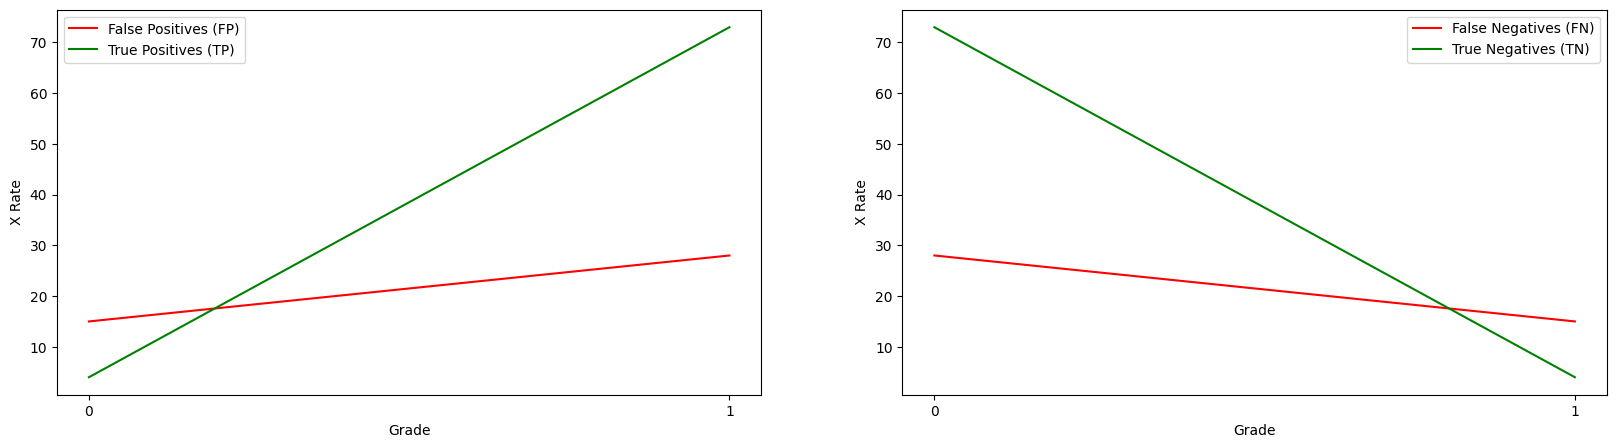

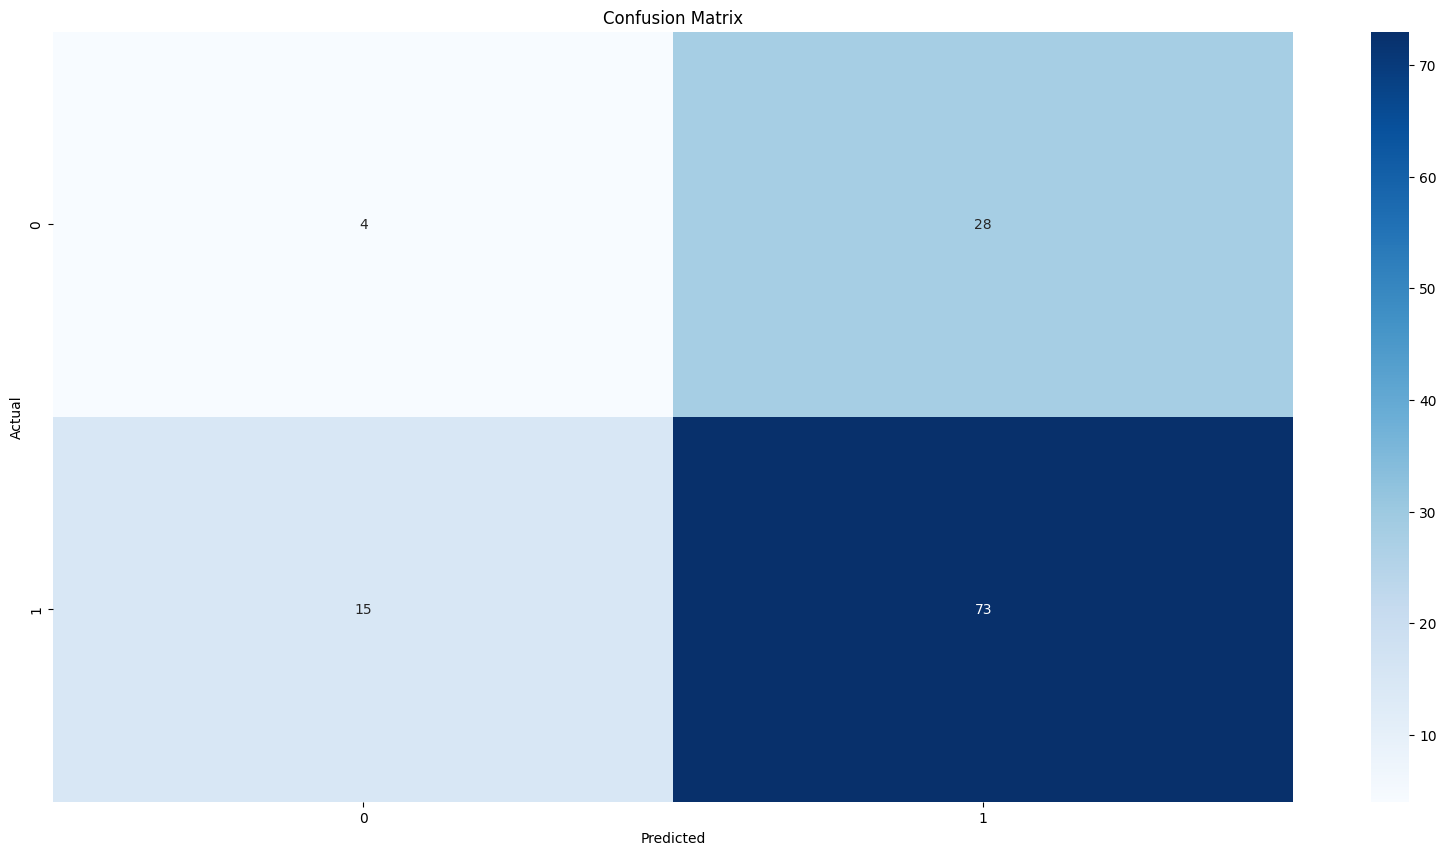

In [ ]:
binary_result = pd.read_csv(RESULT_PATH + "binary_results.csv")

# Evaluate results
evaluation_binary = BinaryEvaluation(binary_result, match='G3')
evaluation_binary.print_stats()
evaluation_binary.plot()
evaluation_binary.plot_confusion_matrix()